# Table of Contents
 <p><div class="lev1"><a href="#Figures-for-AGU2017"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figures for AGU2017</a></div>

In [3]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [37]:
time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx'
N_times = len(time_strides)
N_res = len(resolutions)

print("choose run options")
scaling = 'omega500tsps'
# compset = 'FSPCAMm_AMIP'
compset = 'FAMIPC5'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
dates_label = '185005010100-185105010000'
ranks_label = 'Q8-Q41'
time_ref = '1d'
res_ref = '1dx'

# Results to analyze
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset)

results = {}
for time_stride in time_strides:
    results[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_%s_%s.csv'%(ranks_label,dates_label)
        filepath = os.path.join(resultdir,time_stride,resolution,filename)
        results[time_stride][resolution] = pd.read_csv(filepath)

all_varids = results[time_ref][res_ref].keys()

choose run options


FileNotFoundError: File b'/Users/bfildier/Code/researchProjects/dataAnalysis/extremeRainPredictabilityAcrossScales/results/omega500tsps/FAMIPC5/piControl/r1i1p1/tropics/1h/1dx/results_dataframe_Q8-Q41_185005010100-185105010000.csv' does not exist

In [34]:
varids_to_remove = set(('Unnamed: 0','contrib','ranks_ref'))
varids_to_sum = set(('N_prQ',))
varids_to_avg = set(all_varids).difference(varids_to_remove.union(varids_to_sum))

In [35]:
print("load all variables as a function of time_stride and resolution")

ranks_ref = results[time_strides[0]][resolutions[0]]['ranks_ref']
iQ999 = indexOfRank(99.9,ranks_ref)
iQ_slice = slice(iQ999-5,iQ999+5)

iQ_label = "Q%d_Q%d"%(iQ_slice.start,iQ_slice.stop)

for varid in varids_to_avg:
    newvarid = "%s_%s"%(varid,iQ_label)
    newvar = getTXVarFromResults(varid,results,time_strides,resolutions,iQ_slice,avg_mode='mean')
    setattr(thismodule,newvarid,newvar)

for varid in ('N_prQ',):
    newvarid = "%s_Q%s"%(varid,iQ999)
    newvar = getTXVarFromResults(varid,results,time_strides,resolutions,slice(iQ999,iQ999+1),avg_mode='sum')
    setattr(thismodule,newvarid,newvar)


load all variables as a function of time_stride and resolution


In [36]:
print("compute normalizes bias")
norm_bias_pr_sc_prQ_Q25_Q35 = 1-(pr_sc_vQ_Q25_Q35/pr_sc_prQ_Q25_Q35)

compute normalizes bias


In [12]:
print("sum of covariance terms")
contribQOmega_var_allcov_Q25_Q35 = contribQOmega_var_covQOmega_Q25_Q35+contribQOmega_var_covQ2Omega2_Q25_Q35
contribTOmega_var_allcov_Q25_Q35 = contribTOmega_var_covTOmega_Q25_Q35+contribTOmega_var_covTOmega2_Q25_Q35

sum of covariance terms


In [29]:
print("> Plot normalized variability and contributions")

varids_to_plot = [v for v in locals() if v.endswith(iQ_label) and v.startswith('contrib')]

## Plot bias and variability
for varid in ['norm_bias_pr_sc_prQ_Q25_Q35','norm_var_pr_sc_prQ_Q25_Q35']:
    var = getattr(thismodule,varid)
    # Plot
    fig, ax = plt.subplots(ncols=1,nrows=1)
    if varid.startswith('norm_var_'):
        vmin = 0; vmax = 0.13
        subplotMultiscaleVar(ax,var,time_strides,cmap=plt.cm.Spectral,vmin=vmin,vmax=vmax)
        ax.set_title('Normalized variance')
    elif varid.startswith('norm_bias_'):
        subplotMultiscaleVar(ax,var,time_strides)
        ax.set_title('Normalized bias')
    addHatchBelowThreshold(ax,N_prQ_Q30,40)
    plt.savefig(os.path.join(figdir,'%s_%s.pdf'%(varid,dates_label.replace('-','_'))),bbox_inches='tight')
    plt.close()

## Plot all contributions
for varid in varids_to_plot:
    if '_var_' in varid:
        var = getattr(thismodule,varid)/norm_var_pr_sc_prQ_Q25_Q35*100
    elif '_bias_' in varid:
        var = getattr(thismodule,varid)/norm_bias_pr_sc_prQ_Q25_Q35*100
    # Plot
    fig, ax = plt.subplots(ncols=1,nrows=1)
    subplotMultiscaleVar(ax,var,time_strides,cmap=plt.cm.Spectral,vmin=-120,vmax=120)
    addHatchBelowThreshold(ax,N_prQ_Q30,40)
    plt.savefig(os.path.join(figdir,'fraction_%s_%s.pdf'%(varid,dates_label.replace('-','_'))),bbox_inches='tight')
    plt.close()


> Plot normalized variability and contributions


In [25]:
varids_to_plot

['contribQOmega_var_cov2QOmega_Q25_Q35',
 'contribQOmega_var_varQ_Q25_Q35',
 'contribQOmega_var_covQ2Omega2_Q25_Q35',
 'contribQOmega_bias_covQOmega_Q25_Q35',
 'contribQOmega_var_varQvarOmega_Q25_Q35',
 'contribTOmega_var_covTOmega2_Q25_Q35',
 'contribTOmega_var_varOmega_Q25_Q35',
 'contribTOmega_var_varT_Q25_Q35',
 'contribQOmega_var_sum_Q25_Q35',
 'contribQOmega_var_covQOmega_Q25_Q35',
 'contribTOmega_var_sum_Q25_Q35',
 'contribTOmega_var_covTOmega_Q25_Q35',
 'contribQOmega_var_varOmega_Q25_Q35',
 'contribQOmega_var_allcov_Q25_Q35',
 'contribTOmega_var_allcov_Q25_Q35']

In [17]:
## Draw isocontour samplesize = N_ref
N_ref = 150
x = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],1)
y = N_ref

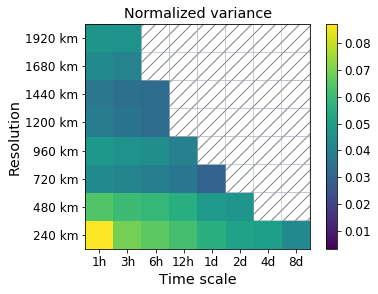

In [24]:
var = norm_var_pr_sc_prQ_Q25_Q35
fig, ax = plt.subplots(ncols=1,nrows=1)
cb = subplotMultiscaleVar(ax,var,time_strides)
ax.set_title('Normalized variance')

addHatchBelowThreshold(ax,N_prQ_Q30,40)